In [1]:
from argparse import Namespace
from utils.utils import llama2_text_processor, llama2_tokenizer, get_image_processor, get_grounding_image_processor
from utils.utils import ItemDataset

[2024-03-25 21:31:49,167] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
args = Namespace(
    from_pretrained="cogagent-vqa",
    local_tokenizer="lmsys/vicuna-7b-v1.5",
    max_length=1024,
    top_p=0.4,
    top_k=1,
    temperature=0.8,
    version="chat_old",
    quant=None,
    fp16=True,
    bf16=False,
    stream_chat=False,
    gnd_image_pix=512,
    use_lora=True,
    eva_args={"image_size": [224,224]},
    cross_image_pix = 1120,
    image_length = 256
)

In [3]:
tokenizer = llama2_tokenizer(args.local_tokenizer, signal_type=args.version)
vg_token = "给"
print("Using VG token: ", vg_token)
args.vg_token_idx = tokenizer.convert_tokens_to_ids(vg_token)
print("VG token index: ", args.vg_token_idx) # 31999
assert args.vg_token_idx == tokenizer.convert_tokens_to_ids(vg_token)

Using VG token:  给
VG token index:  31999


In [4]:
image_processor = get_image_processor(args.eva_args["image_size"][0])
cross_image_processor = get_image_processor(args.cross_image_pix)
grounding_image_processor = get_grounding_image_processor(args.gnd_image_pix)
text_processor = llama2_text_processor(tokenizer, args.max_length, args.image_length)

In [5]:
dataset = ItemDataset(image_processor, text_processor, args, "data/json/apollo_ferret_noscale.json", cross_image_processor=cross_image_processor, grounding_image_processor = grounding_image_processor,vg_token=vg_token)
print("Created dataset with {} items".format(len(dataset)))

[2024-03-25 21:31:53,264] [INFO] find 15723 samples in all...


all_data: {'Question': 'Task: Give me a list of all the researchers in United States working for Microsoft with at least 5 years of experience. \n Previous Action: TYPE: Type Total Years of Experience in the Search filters tab \nGive me the next action?', 'Answer': "Reasoning: After typing 'Total Years of Experience' in the Search filters tab, we need to click the corresponding tab to apply this filter. This will help us refine our search in accordance with the task requirements. CLICK: Click on the Total Years of Experience [0.179,0.452,0.385,0.51] button", 'workflow': 'anurag-wf-10_augmented_cropped', 'imagePath': '/workspace/CogAgent/data//images-augmented-cropped/67_augmented_cropped_s.png'}
Creating dataset using the VG token:  给
Created dataset with 15723 items


In [6]:
first_item = dataset[0]
# print all keys in the first item
for key, value in first_item.items():
    print(key, end=", ")
print("\n")

# vision, cross, gndimg, ratios, input_ids, labels, position_ids, attention_mask, image_embed_mask, context_length
# image_position, vision_expert_mask, image_rope_mask, bboxes_gt_list, question_id
# bbox_original_percentage_pixel, bbox_original, image_path, bbox_cxcywh_gnd_percentage_pixel,label, prompt 

print("label: ", first_item["label"])
print("prompt: ", first_item["prompt"])

vision, cross, gndimg, ratios, input_ids, labels, position_ids, attention_mask, image_embed_mask, context_length, image_position, vision_expert_mask, image_rope_mask, bboxes_gt_list, question_id, bbox_original_percentage_pixel, bbox_original, image_path, bbox_cxcywh_gnd_percentage_pixel, label, prompt, 

label:  Reasoning: After typing 'Total Years of Experience' in the Search filters tab, we need to click the corresponding tab to apply this filter. This will help us refine our search in accordance with the task requirements. CLICK: Click on the Total Years of Experience button给
prompt:  Task: Give me a list of all the researchers in United States working for Microsoft with at least 5 years of experience. 
 Previous Action: TYPE: Type Total Years of Experience in the Search filters tab 
Give me the next action?


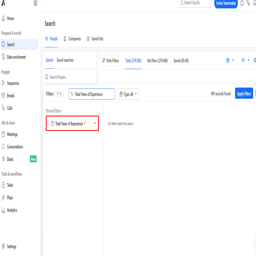

In [7]:
# Draw bounding boxes on the image using bbox_original (Format is [x1, y1, x2, y2])
from PIL import Image
image_path = first_item["image_path"]
image = Image.open(image_path)
from PIL import ImageDraw
draw = ImageDraw.Draw(image)
draw.rectangle(first_item["bbox_original"], outline="red", width=3)
image.thumbnail((256, 256))
image.show()


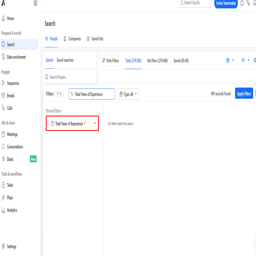

In [8]:
# Draw bounding boxes on the image using bbox_original_percentage_pixel (Format is [x1, y1, x2, y2])
from PIL import Image
from PIL import ImageDraw
image_path = first_item["image_path"]
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
bbox = first_item["bbox_original_percentage_pixel"]
bbox = [bbox[0]*image.width, bbox[1]*image.height, bbox[2]*image.width, bbox[3]*image.height]
draw.rectangle(bbox, outline="red", width=3)
image.thumbnail((256, 256))
image.show()

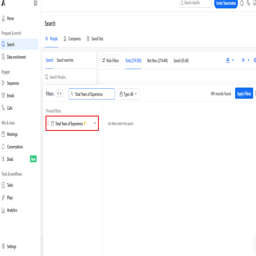

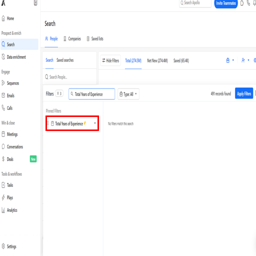

In [9]:
# Draw bounding boxes on the image using bbox_cxcywh_gnd_percentage_pixel (Format is [cx, cy, w, h] - scaled as per grounding image size)
from PIL import Image
from PIL import ImageDraw
image_path = first_item["image_path"]
w,h = grounding_image_processor.image_size
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
bbox = first_item["bbox_cxcywh_gnd_percentage_pixel"]
bbox = [bbox[0]*w, bbox[1]*h, bbox[2]*w, bbox[3]*h]
xy_form_bbox = [bbox[0]-bbox[2]/2, bbox[1]-bbox[3]/2, bbox[0]+bbox[2]/2, bbox[1]+bbox[3]/2]

# Method 1 of drawing -> Rescale the bounding box to the original image size
ratio_width, ratio_height = first_item["ratios"]
final_bbox = [xy_form_bbox[0]/ratio_width, xy_form_bbox[1]/ratio_height, xy_form_bbox[2]/ratio_width, xy_form_bbox[3]/ratio_height]
draw.rectangle(final_bbox, outline="red", width=3)
image.thumbnail((256, 256))
image.show()

# Method 2 of drawing -> Rescale the image to the grounding image size
image = Image.open(image_path)
image = image.resize((w,h))
draw = ImageDraw.Draw(image)
draw.rectangle(xy_form_bbox, outline="red", width=3)
image.thumbnail((256, 256))
image.show()

In [10]:
# Debugging text inputs
for key, value in first_item.items():
    print(key,": ", value)

vision :  {'image': tensor([[[[ 1.9303,  1.9303,  0.3245,  ...,  1.7844,  1.2734,  1.2442],
          [ 1.9303,  1.8719, -0.2010,  ...,  1.6968,  1.5362,  1.4340],
          [ 1.9303,  1.4486, -0.2448,  ...,  1.6384,  1.6092,  1.4486],
          ...,
          [ 1.9303,  1.9303,  1.9303,  ...,  1.9011,  1.8865,  1.8573],
          [ 1.9303,  1.9303,  1.9303,  ...,  1.9157,  1.9011,  1.8865],
          [ 1.9303,  1.9303,  1.9303,  ...,  1.9157,  1.9011,  1.8865]],

         [[ 2.0749,  2.0749,  0.4240,  ...,  1.8948,  1.4145,  1.3845],
          [ 2.0749,  2.0149, -0.1163,  ...,  1.8047,  1.6997,  1.5496],
          [ 2.0749,  1.5796, -0.1613,  ...,  1.7447,  1.7897,  1.5646],
          ...,
          [ 2.0749,  2.0749,  2.0749,  ...,  2.0449,  2.0299,  1.9998],
          [ 2.0749,  2.0749,  2.0749,  ...,  2.0599,  2.0449,  2.0299],
          [ 2.0749,  2.0749,  2.0749,  ...,  2.0599,  2.0449,  2.0299]],

         [[ 2.1459,  2.1459,  0.5817,  ...,  1.9468,  1.5060,  1.5060],
          

In [14]:
print("attention_mask matrix: ", first_item['attention_mask'].shape) # torch.Size([1, 1, 1024, 1024])
print("attention_mask: ", first_item['attention_mask']) # tensor([[[[1, 0, 0,  ..., 0, 0, 0], [1, 1, 0,  ..., 0, 0, 0], [1, 1, 1,  ..., 0, 0, 0],  ..., [1, 1, 1,  ..., 1, 0, 0], [1, 1, 1,  ..., 1, 1, 0], [1, 1, 1,  ..., 1, 1, 1]]]])

print("\nimage_embed_mask")
print(first_item['image_embed_mask'].shape) # torch.size([1, 1024]) # tensor([[0, 1, 1,  ..., 0, 0, 0]])
print("Numeber of 1s in image_embed_mask: ", first_item['image_embed_mask'].sum())
list_indices_image_embed_mask = []
for i, val in enumerate(first_item['image_embed_mask'][0]):
    if val == 1:
        list_indices_image_embed_mask.append(i)
print("List of indices where image_embed_mask is 1: ", list_indices_image_embed_mask)

print("\nvision_expert_mask")
print(first_item['vision_expert_mask'].shape) # torch.size([1, 1024]) # tensor([[0, 1, 1,  ..., 0, 0, 0]])
print("Numeber of 1s in vision_expert_mask: ", first_item['vision_expert_mask'].sum())
list_indices_vision_expert_mask = []
for i, val in enumerate(first_item['vision_expert_mask'][0]):
    if val == 1:
        list_indices_vision_expert_mask.append(i)
print("List of indices where vision_expert_mask is 1: ", list_indices_vision_expert_mask)


print("\nimage_rope_mask")
print(first_item['image_rope_mask'].shape) # torch.size([1, 1024]) # tensor([[0, 1, 1,  ..., 0, 0, 0]])
print("Numeber of 1s in image_rope_mask: ", first_item['image_rope_mask'].sum())
list_indices_image_rope_mask = []
for i, val in enumerate(first_item['image_rope_mask'][0]):
    if val == 1:
        list_indices_image_rope_mask.append(i)
print("List of indices where image_rope_mask is 1: ", list_indices_image_rope_mask)

# This should be 1, the last token (Due to size difference of 1)
print("Number of indices where vision expert mask and image embed mask are different: ", (first_item['vision_expert_mask'] != first_item['image_embed_mask']).sum().item())

# This should be 1, the last token (Due to size difference of 1)
print("Number of indices where vision expert mask and image rope mask are different: ", (first_item['vision_expert_mask'] != first_item['image_rope_mask']).sum().item())

print("\nContext Length: ", first_item['context_length'].item()) # 318

print("\nPosition IDs")
print(first_item['position_ids'].shape) # torch.Size([1, 1024]) # tensor([[  0,   1,   2,  ..., 766, 767, 768]])
print("Position IDs: ", first_item['position_ids']) # Position IDs:  
# position_ids indices list where value is 0
print("List of indices where position_ids is 0: ", (first_item['position_ids'][0] == 0).nonzero(as_tuple=True)[0].tolist())
# position_ids indices list where value is 1
print("List of indices where position_ids is 1: ", (first_item['position_ids'][0] == 1).nonzero(as_tuple=True)[0].tolist())
# position_ids indices list where value is 2
print("Length of list of indices where position_ids is 2: ", len((first_item['position_ids'][0] == 2).nonzero(as_tuple=True)[0].tolist()))
# Iterate from index 258 onwards and check if the values are continuous from 3 to 768
is_continuous = True
for i, val in enumerate(first_item['position_ids'][0][258:]):
    if val != i+3:
        is_continuous = False
        break
print("Are the values from index 258 onwards continuous from 3 to 768: ", is_continuous)

attention_mask matrix:  torch.Size([1, 1, 1024, 1024])
attention_mask:  tensor([[[[1, 0, 0,  ..., 0, 0, 0],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 0, 0],
          [1, 1, 1,  ..., 1, 1, 0],
          [1, 1, 1,  ..., 1, 1, 1]]]])

image_embed_mask
torch.Size([1, 1024])
Numeber of 1s in image_embed_mask:  tensor(258)
List of indices where image_embed_mask is 1:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 13

In [15]:
print("Context Length: ", first_item['context_length'].item()) # 318

# Debug labels
print(first_item['labels']) # tensor([[-100, -100, -100,  ..., -100, -100, -100]])
# Print the values of the labels where the value is not -100
label_list = first_item['labels'][first_item['labels'] != -100].tolist()
print("Size of label_list: ", len(label_list))
print("Labels: ", label_list)

# Decode label_list to text
print("Decoded labels: ", tokenizer.decode(label_list))

# Now debug input_ids
print("Input_ids: ", first_item['input_ids']) # tensor([[1, 0, 0,  ..., 0, 0, 0]])

# print the values of the input_ids where the value is not 0
input_list = first_item['input_ids'][first_item['input_ids'] != 0].tolist()
print("Size of input_list: ", len(input_list))
print("Input list: ", input_list)

# Decode input_list to text
print("Decoded input_list: ", tokenizer.decode(input_list))

Context Length:  318
tensor([[-100, -100, -100,  ..., -100, -100, -100]])
Size of label_list:  62
Labels:  [830, 1658, 292, 29901, 2860, 19229, 525, 11536, 23857, 310, 28224, 5597, 29915, 297, 278, 11856, 18094, 4434, 29892, 591, 817, 304, 2828, 278, 6590, 4434, 304, 3394, 445, 4175, 29889, 910, 674, 1371, 502, 2143, 457, 1749, 2740, 297, 15017, 749, 411, 278, 3414, 11780, 29889, 17332, 2965, 29968, 29901, 16297, 373, 278, 14990, 23857, 310, 28224, 5597, 2826, 31999, 2]
Decoded labels:  Reasoning: After typing 'Total Years of Experience' in the Search filters tab, we need to click the corresponding tab to apply this filter. This will help us refine our search in accordance with the task requirements. CLICK: Click on the Total Years of Experience button给</s>
Input_ids:  tensor([[1, 0, 0,  ..., 0, 0, 0]])
Size of input_list:  122
Input list:  [1, 894, 29901, 9330, 29901, 25538, 592, 263, 1051, 310, 599, 278, 5925, 414, 297, 3303, 3900, 1985, 363, 7783, 411, 472, 3203, 29871, 29945, 2440,